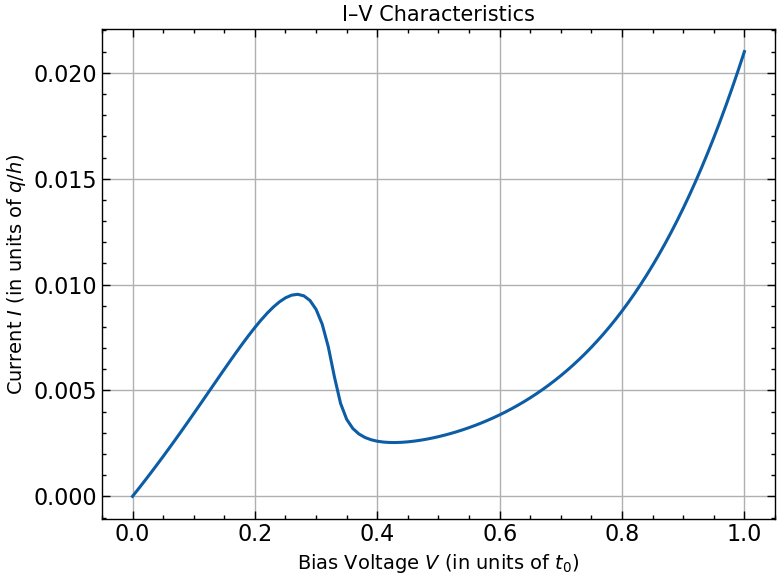

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use(["science", "notebook"])

# === Parameters ===
t0 = 1.0
Np = 11
N1, N2 = 3, 9
UB1 = 2 * t0
UB2 = 2 * t0
zplus = 1j * 1e-12
dE = 5e-4
E_list = np.arange(-0.5, 1.5 + dE, dE) * t0
kT = 0.1 * t0
q = 1.0
h = 1.0

# === Voltage range === 
V_list = np.linspace(0, 1.0, 101)
I_list = []

# === Common diagonals ===
main_diag = 2 * t0 * np.ones(Np)
off_diag = -t0 * np.ones(Np - 1)

# Hamiltonian with two scatterers
H0 = np.diag(main_diag) + np.diag(off_diag, 1) + np.diag(off_diag, -1)
H0[N1, N1] += UB1
H0[N2, N2] += UB2

    

for VV in V_list:
    UV = np.linspace(VV/2,-VV/2, Np)  # Linear potential drop
    U = np.diag(UV)

    T_E = []

    for EE in E_list:
        # Self-energies
        ck1 = 1 - (EE - UV[0] + zplus) / (2 * t0)
        ka1 = np.arccos(ck1) if np.abs(ck1) <= 1 else 1j * np.arccosh(np.abs(ck1))
        s1 = -t0 * np.exp(1j * ka1)
        Sigma1 = np.zeros((Np, Np), dtype=complex)
        Sigma1[0, 0] = s1

        ck2 = 1 - (EE - UV[-1] + zplus) / (2 * t0)
        ka2 = np.arccos(ck2) if np.abs(ck2) <= 1 else 1j * np.arccosh(np.abs(ck2))
        s2 = -t0 * np.exp(1j * ka2)
        Sigma2 = np.zeros((Np, Np), dtype=complex)
        Sigma2[-1, -1] = s2

        # Broadening
        Gamma1 = 1j * (Sigma1 - Sigma1.conj().T)
        Gamma2 = 1j * (Sigma2 - Sigma2.conj().T)

        # Green's function
        G_R = np.linalg.inv((EE + zplus) * np.eye(Np) - H0 - U - Sigma1 - Sigma2)

        # Transmission
        T = np.real(np.trace(Gamma1 @ G_R @ Gamma2 @ G_R.conj().T))
        T_E.append(T)

    T_E = np.array(T_E)

    # Fermi functions
    mu1 = +VV/2
    mu2 = -VV/2
    f1 = 1 / (1 + np.exp((E_list - mu1) / kT))
    f2 = 1 / (1 + np.exp((E_list - mu2) / kT))

    # Current via Landauer
    integrand = T_E*(f1-f2)
    I = (q / h) * np.sum(integrand)*dE
    I_list.append(I)

# === Plotting I–V ===
plt.figure(figsize=(8, 6))
plt.plot(V_list, I_list, linewidth=2.2)
plt.xlabel(r"Bias Voltage $V$ (in units of $t_0$)", fontsize=14)
plt.ylabel(r"Current $I$ (in units of $q/h$)", fontsize=14)
plt.title("I–V Characteristics", fontsize=15)
plt.grid(True)
# plt.xlim(0,1)
plt.tight_layout()
plt.show()

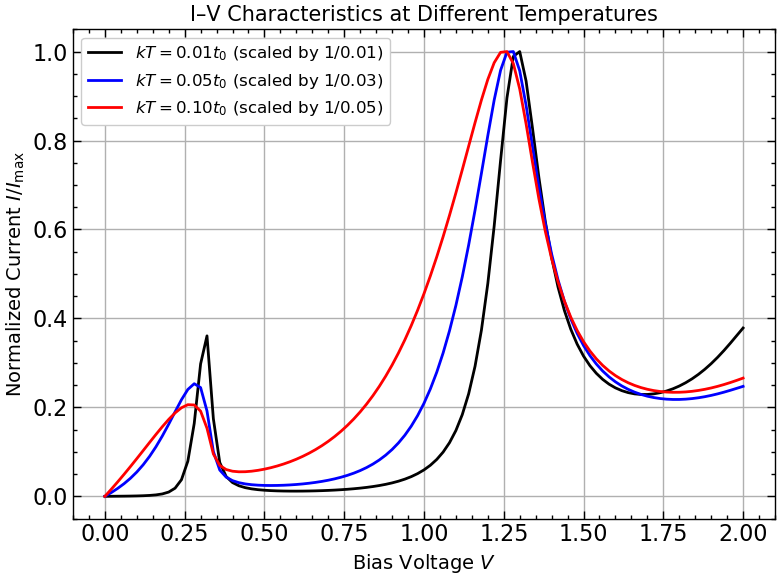

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
plt.style.use(['science', 'notebook'])

# === Parameters ===
t0 = 1.0
Np = 11
N1, N2 = 3, 9
UB1 = 2 * t0
UB2 = 2 * t0
zplus = 1j * 1e-12
dE = 5e-4
E_list = np.arange(-0.5, 1.5 + dE, dE) * t0
q = 1.0
h = 1.0

# === Voltage range ===
V_list = np.linspace(0, 2.0, 101)

H0 = np.diag(main_diag) + np.diag(off_diag, 1) + np.diag(off_diag, -1)
H0[N1, N1] += UB1
H0[N2, N2] += UB2

@njit
def compute_transmission(E_list, UV, main_diag, off_diag, t0, Np, N1, N2, UB1, UB2, zplus):
    T_E = np.zeros(len(E_list))
    for idx in range(len(E_list)):
        EE = E_list[idx]
        U = np.diag(UV)

        ck1 = 1 - (EE - UV[0] + zplus) / (2 * t0)
        if np.abs(ck1) <= 1:
            ka1 = np.arccos(ck1)
        else:
            ka1 = 1j * np.arccosh(np.abs(ck1))
        s1 = -t0 * np.exp(1j * ka1)
        Sigma1 = np.zeros((Np, Np), dtype=np.complex128)
        Sigma1[0, 0] = s1

        ck2 = 1 - (EE - UV[-1] + zplus) / (2 * t0)
        if np.abs(ck2) <= 1:
            ka2 = np.arccos(ck2)
        else:
            ka2 = 1j * np.arccosh(np.abs(ck2))
        s2 = -t0 * np.exp(1j * ka2)
        Sigma2 = np.zeros((Np, Np), dtype=np.complex128)
        Sigma2[-1, -1] = s2

        Gamma1 = 1j * (Sigma1 - Sigma1.conj().T)
        Gamma2 = 1j * (Sigma2 - Sigma2.conj().T)

        G_R = np.linalg.inv((EE + zplus) * np.eye(Np) - H0 - U - Sigma1 - Sigma2)
        T = np.real(np.trace(Gamma1 @ G_R @ Gamma2 @ G_R.conj().T))
        T_E[idx] = T

    return T_E

# === Temperature values to compare ===
kT_values = [0.01 * t0, 0.05 * t0, 0.1 * t0]
currents = []
scaling_factors = []

main_diag = 2 * t0 * np.ones(Np)
off_diag = -t0 * np.ones(Np - 1)

for kT in kT_values:
    I_list = []
    for VV in V_list:
        UV = np.linspace(VV / 2, -VV / 2, Np)
        T_E = compute_transmission(E_list, UV, main_diag, off_diag, t0, Np, N1, N2, UB1, UB2, zplus)
        mu1 = +VV / 2
        mu2 = -VV / 2
        f1 = 1 / (1 + np.exp((E_list - mu1) / kT))
        f2 = 1 / (1 + np.exp((E_list - mu2) / kT))
        integrand = T_E * (f1 - f2)
        I = (q / h) * np.sum(integrand) * dE
        I_list.append(I)
    I_array = np.array(I_list)
    scaling_factors.append(np.max(I_array))
    currents.append(I_array / np.max(I_array))  # normalize for fair comparison

# === Plot I–V for different temperatures ===
fig, ax = plt.subplots(figsize=(8, 6))
colors = ['black', 'blue', 'red']
for i, kT in enumerate(kT_values):
    label = fr"$kT = {kT/t0:.2f} t_0$ (scaled by 1/{scaling_factors[i]:.2f})"
    ax.plot(V_list, currents[i], label=label, color=colors[i], linewidth=2)

ax.set_xlabel(r"Bias Voltage $V$", fontsize=14)
ax.set_ylabel(r"Normalized Current $I / I_{\mathrm{max}}$", fontsize=14)
ax.set_title("I–V Characteristics at Different Temperatures", fontsize=15)
ax.grid(True)
ax.legend(fontsize=12, frameon=True, facecolor='white', framealpha=1.0)

plt.tight_layout()
plt.show()

